In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [1]:
np.random.seed(seed=0)

N = 2000  #Number of neurons 
dt = 5e-5
tref = 2e-3 #Refractory time constant in seconds
tm = 1e-2 #Membrane time constant 
vreset = -65 #Voltage reset 
vthr = -40 #Voltage threshold
vpeak = 30

td = 2e-2
tr = 2e-3

alpha = dt*0.1 #Sets the rate of weight change, too fast is unstable, too slow is bad as well.  
Pinv = np.eye(N)*alpha #initialize the correlation weight matrix for RLMS
p = 0.1 #Set the network sparsity 


#Target Dynamics for Product of Sine Waves
T = 15 # Simulation time (s)
imin = round(5/dt) # beginning time step of RLS training 
icrit = round(10/dt) # end time step of RLS training
step = 50 # weights update time step
nt = round(T/dt) # Simulation time step
Q = 10; G = 0.04;
zx = np.sin(2*math.pi*np.arange(nt)*dt*5) # Target signal

k = 1 # number of output unit
IPSC = np.zeros(N) #post synaptic current storage variable 
h = np.zeros(N) #Storage variable for filtered firing rates
r = np.zeros((N,1)) #second storage variable for filtered rates 
hr = np.zeros(N) #Third variable for filtered rates 
JD = np.zeros(N) #storage variable required for each spike time 
tspike = np.zeros((4*nt,2)) #Storage variable for spike times 
ns = 0 #Number of spikes, counts during simulation  
z = np.zeros(k) #Initialize the approximant 
 
v = vreset + np.random.rand(N)*(vpeak-vreset) #Initialize neuronal voltage with random distribtuions


OMEGA = G*(np.random.randn(N,N))*(np.random.rand(N,N)<p)/(math.sqrt(N)*p) #The initial weight matrix with fixed random weights  
BPhi = np.zeros(N) #The initial matrix that will be learned by FORCE method

#Set the row average weight to be zero, explicitly.
for i in range(N):
    QS = np.where(np.abs(OMEGA[i,:])>0)[0]
    OMEGA[i,QS] = OMEGA[i,QS] - np.sum(OMEGA[i,QS], axis=0)/len(QS)

E = (2*np.random.rand(N)-1)*Q #n

# arrays to save
RECB = np.zeros((nt, 10)) #Storage matrix for the synaptic weights (a subset of them) 
REC2 = np.zeros((nt,20))
REC = np.zeros((nt,10))
current = np.zeros(nt) #storage variable for output current/approximant 

tlast = np.zeros(N) #This vector is used to set  the refractory times 
BIAS = vthr #Set the BIAS current, can help decrease/increase firing rates.  0 is fine.

In [2]:
nt = 1

In [3]:
for i in tqdm(range(nt)):
    I = IPSC + E*z + BIAS #Neuronal Current 
    dv = ((dt*i) > (tlast + tref))*(-v + I) / tm #Voltage equation with refractory period 
    v = v + dt*dv
    
    index = np.where(v>=vthr)[0] #Find the neurons that have spiked 
    
    # Store spike times, and get the weight matrix column sum of spikers 
    len_idx = len(index)
    if len_idx>0:
        JD = np.sum(OMEGA[:, index], axis=1) #compute the increase in current due to spiking  
        tspike[ns:ns+len_idx,:] = np.vstack((index, 0*index+dt*i)).T
        ns = ns + len_idx # total number of psikes so far

    tlast = tlast + (dt*i - tlast)*(v>=vthr) #Used to set the refractory period of LIF neurons 
 
    # Code if the rise time is 0, and if the rise time is positive 
    if tr == 0:  
        # synapse for single exponential 
        IPSC = IPSC*math.exp(-dt/td) + JD*(len_idx>0)/td
        r = r[:,0]*math.exp(-dt/td) + (v>=vthr)/td
    else:
        # synapse for double exponential
        IPSC = IPSC*math.exp(-dt/tr) + h*dt        
        h = h*math.exp(-dt/td) + JD*(len_idx>0)/(tr*td) #Integrate the current        
        r = r[:,0]*math.exp(-dt/tr) + hr*dt 
        hr = hr*math.exp(-dt/td) + (v>=vthr)/(tr*td)
    
    r = np.expand_dims(r,1) # (N,) -> (N, 1)
    
    # Implement RLMS with the FORCE method 
    z = BPhi.T @ r #approximant 
    err = z - zx[i] #error 

    # RLMS 
    if i % step == 1:
        if i > imin:
            if i < icrit:
                cd = (Pinv @ r)
                BPhi = BPhi - (cd @ err.T)
                Pinv = Pinv - (cd @ cd.T) / (1.0 + r.T @ cd)
    
    v = v + (vpeak - v)*(v>=vthr) # set peak voltage
    
    REC[i] = v[:10] #Record a random voltage 
    
    v = v + (vreset - v)*(v>=vthr) #reset with spike time interpolant implemented.
    
    current[i] = z
    RECB[i,:] = BPhi[:10]  
    REC2[i,:] = r[:20,0]

100%|██████████| 1/1 [00:00<00:00, 27.36it/s]


In [4]:
np.sum(OMEGA[:, index], axis=1)

array([ 0.03489599, -0.01047135,  0.08708232, ..., -0.0718441 ,
       -0.03307458, -0.00837583])

In [5]:
r[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

In [6]:
r

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [8]:
np.tile([1,2], 4)

array([1, 2, 1, 2, 1, 2, 1, 2])

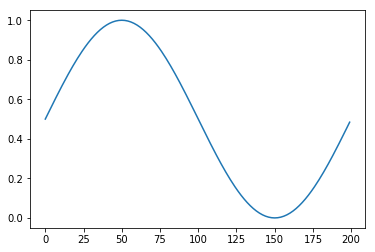

In [11]:
nTs = 200
y = 0.5+0.5*np.sin((np.pi/(0.5*nTs))*np.arange(nTs))
plt.plot(y)

In [31]:
inp = np.empty((2,3))
inpTile = np.tile(inp, (10,*inp.shape))
inpTile.shape

(10, 4, 9)

(10, 200)


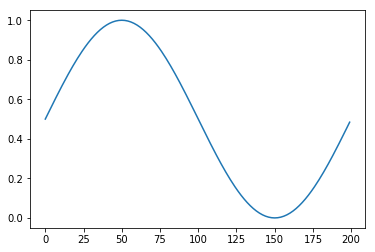

In [23]:
y2 = np.tile(y, (10,1))
plt.plot(y2[2])
print(y2.shape)

In [36]:
inpTile = np.repeat(inp[np.newaxis,...], 10, axis=0)
inpTile.shape

(10, 2, 3)

In [31]:
spikes = (np.random.rand(2,3) > 0.5).astype(int)
spikes

array([[1, 1, 1],
       [1, 1, 1]])

In [32]:
flips = np.random.rand(2,3) > 0.8
flips

array([[ True, False, False],
       [False, False, False]])

In [33]:
np.logical_xor(spikes, flips).astype(int)

array([[0, 1, 1],
       [1, 1, 1]])

In [21]:
pp = (np.random.rand(10) < 0.2)
pp

array([ True, False, False, False,  True,  True,  True, False, False,
       False])

In [39]:
tt = [ np.where(pp)[0] + 10 + i*50 for i in range(5) ]
print(tt)

[array([10, 14, 15, 16]), array([60, 64, 65, 66]), array([110, 114, 115, 116]), array([160, 164, 165, 166]), array([210, 214, 215, 216])]


In [40]:
import itertools

In [44]:
list(itertools.chain(*tt))

[10,
 14,
 15,
 16,
 60,
 64,
 65,
 66,
 110,
 114,
 115,
 116,
 160,
 164,
 165,
 166,
 210,
 214,
 215,
 216]